##### modeling and interpretation notebook--train, test, and conclude
***

# Importing Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Import Model Specific Libraries

In [47]:
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split

import math

### Reopening our cleaned dataframe

In [3]:
pd.set_option('display.max_columns', 999)  # setting to view all columns

with open('data/data-drops.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data_drops_df = pickle.load(f)

print("Dataframe successfully imported from pickle.\n\n")
display(data_drops_df.shape)
data_drops_df.head()

Dataframe successfully imported from pickle.




(19322, 16)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,Sqft_basement,zipcode,lat,long,Renovated
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,0,98178,47.5112,-122.257,0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,400,98125,47.7210,-122.319,1
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,6,0,98028,47.7379,-122.233,0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,910,98136,47.5208,-122.393,0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,0,98074,47.6168,-122.045,0


# Questions

We have already found that some predictors could be eliminated, due to their lack of correlation or linearity with the response variable. We also eliminated some variables from our study, due to their collinearity with others.

We can begin investigating our remaining questions by building and testing a model, selecting and eliminating features, and adjusting variable coefficients along the way.

> As a reminder of our remaining basic questions:
1. ~~mean price~~
2. mean price within 20 miles of the city center
3. ~~mean bedrooms of home sales (roomates or rentals)~~
4. ~~which influences price more: the number of bedrooms or the number of square feet~~
5. ~~do renovations make a significant difference in such a competitive market~~


We may have already answered question 5, but we will let the model decide for sure.

# Correlations
### Seeing where we stand

In [4]:
# creating a correlations table with absolute values
dd_corr = data_drops_df.corr()

Tthe dataframe can be visually ordered to be more useful. We can order the columns by the strength of their correlation with price, so that is what we will do.

### Sorting columns in order of correlation with `price`

In [5]:
# instantiating a sorted correlation
dd_sort_ix = dd_corr.sort_values(
    'price', ascending=False).index

# creating a variable for sorted correlation indexes
dd_sortix = data_drops_df.loc[:, dd_sort_ix]

### Viewing the sorted correlations table

In [6]:
# view without `id`
dds = dd_sortix.drop(['id'], axis=1).corr()

# view the correlations table
dds

,price,grade,sqft_living,bathrooms,lat,bedrooms,floors,Sqft_basement,view,Renovated,sqft_lot,condition,waterfront,long
price,1.000000,0.618932,0.609295,0.434373,0.413889,0.290800,0.270389,0.226851,0.200093,0.105261,0.070791,0.054149,0.024650,0.010399
grade,0.618932,1.000000,0.699486,0.613053,0.107739,0.335893,0.472663,0.057838,0.110132,0.000614,0.110850,-0.158711,0.010195,0.195652
sqft_living,0.609295,0.699486,1.000000,0.709376,0.033682,0.611205,0.366256,0.349491,0.129183,0.037033,0.202151,-0.060647,0.006378,0.250404
bathrooms,0.434373,0.613053,0.709376,1.000000,-0.000954,0.491025,0.520187,0.210283,0.071480,0.030984,0.036630,-0.130666,0.002532,0.230994
lat,0.413889,0.107739,0.033682,-0.000954,1.000000,-0.036622,0.037467,0.122920,0.015593,0.029110,-0.061206,-0.008453,-0.006727,-0.144036
bedrooms,0.290800,0.335893,0.611205,0.491025,-0.036622,1.000000,0.168740,0.272649,0.036044,0.010425,0.109847,0.028922,-0.009423,0.143168
floors,0.270389,0.472663,0.366256,0.520187,0.037467,0.168740,1.000000,-0.286285,-0.007517,-0.000451,-0.121772,-0.268026,0.000495,0.126038
Sqft_basement,0.226851,0.057838,0.349491,0.210283,0.122920,0.272649,-0.286285,1.000000,0.154804,0.049206,0.029763,0.184148,0.011890,-0.178279
view,0.200093,0.110132,0.129183,0.071480,0.015593,0.036044,-0.007517,0.154804,1.000000,0.038026,0.024076,0.035759,0.058646,-0.080293
Renovated,0.105261,0.000614,0.037033,0.030984,0.029110,0.010425,-0.000451,0.049206,0.038026,1.000000,0.006567,-0.055597,0.021866,-0.057528


We can easily see by column location that `grade` is most strongly correlated with price, followed by `sqft_living`. The weakest correlation to price and the furthest column is longitude, followed by `waterfront`. We can inspect this visually as a heatmap.

In [7]:
# create a function to generate a heatmap
def plot_corr_heatmap(cor, cmap="BuPu"):
    # creating a figure to plot a heatmap from correlations
    plt.figure(figsize=(21,18))
    sns.set(font_scale=1.5, color_codes=True) # making annotations legible
    # plotting
    sns.heatmap(cor.round(2).abs(), center=.8, annot=True, cmap="YlGnBu")
    plt.tick_params(axis="both", which="both", bottom=False, top=True,    
                labelbottom=False, labeltop=True,left=True, 
                    right=False, labelleft=True)
    plt.xticks(rotation = 70, fontsize=20)
    plt.yticks(fontsize=20)
    plt.autoscale() # prevent cropping
    plt.show()

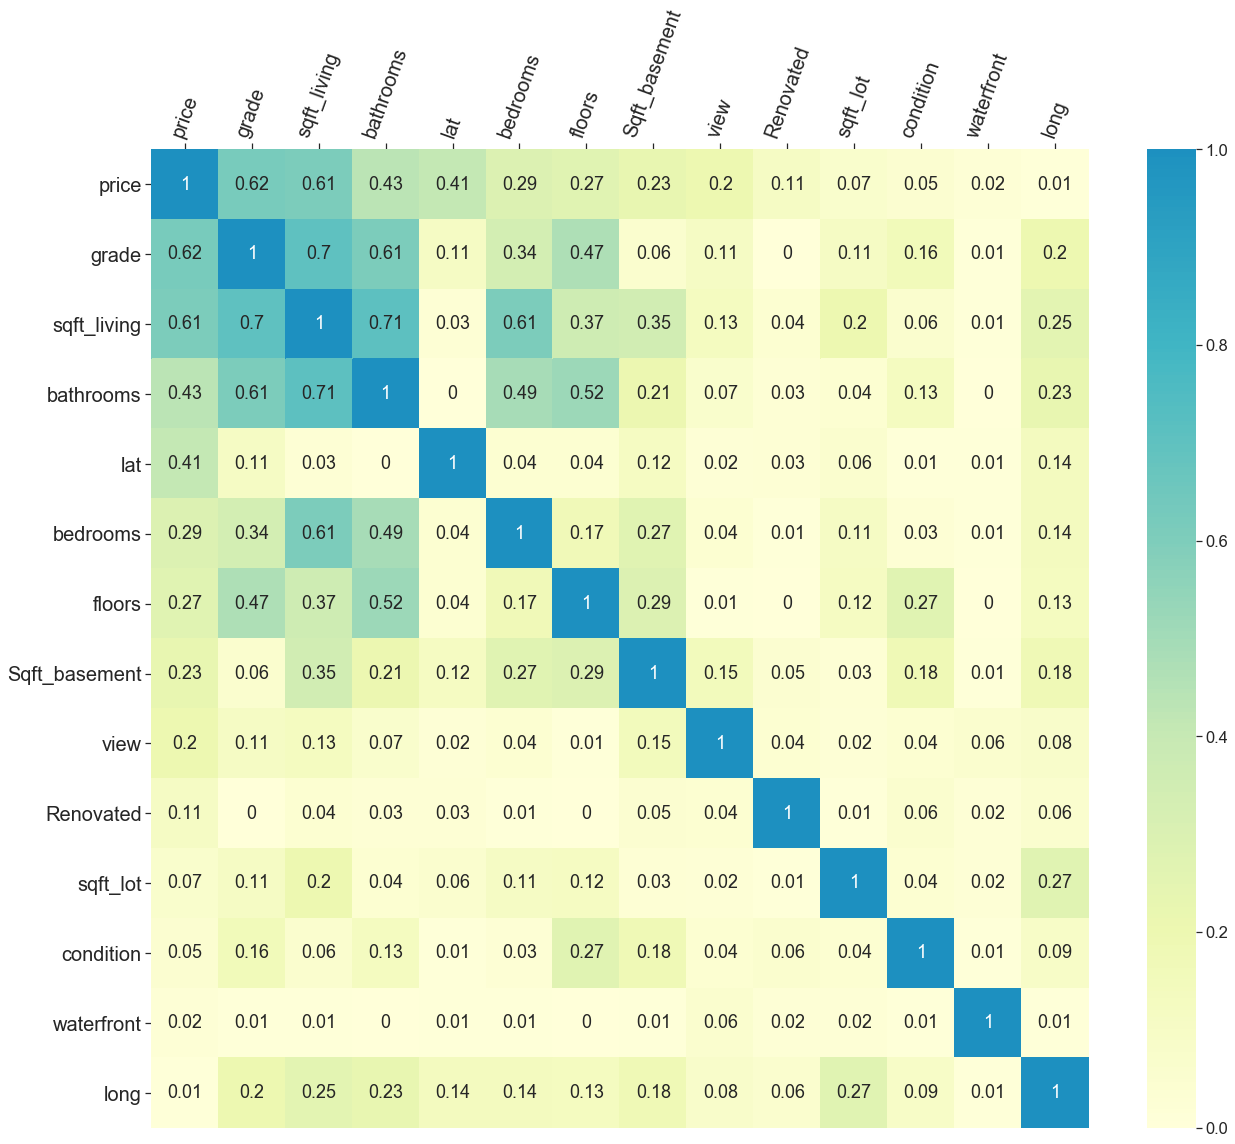

In [8]:
# displaying the heatmap
plot_corr_heatmap(dds)

This is a fairly clear indicator that `grade` and `sqft_living` are strong predictors. We also note, however, that the two appear to be strongly collinear. In addition, each appears to be strongly collinear with `bathrooms`, the next strongest feature.

## Instinct

> My instinct is that zipcode is important ('location, location, location'), and that combining it with 'sqft_living' or 'grade' will be definitive. However, I do want to test other features to see whether they reveal any unexpected value.

We can at this point eliminate a few weak predictors for price. At the risk of contradicting myself, and at the expense of my curiosity, I think it is fair to eliminate anything below 0.1: that comprises `long`, `waterfront`, `condition`, and `sqft_lot`.

## Dropping weak correlations

We will copy a new dataframe for modeling and testing.

In [9]:
# time to drop that `id` column
data_drops_df.drop('id', axis=1, inplace=True)

# creating `mod_df` as a copy of `data_drops_df`
mod_df = data_drops_df.copy()

# viewing first rows
mod_df.head(2)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,Sqft_basement,zipcode,lat,long,Renovated
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,0,98178,47.5112,-122.257,0
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,400,98125,47.7210,-122.319,1


In [10]:
# removing the `long`, `waterfront`, `condition`, and `sqft_lot` columns
mod_df.drop(['long', 'waterfront', 'condition', 'sqft_lot'], axis=1, inplace=True)

mod_df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'view',
       'grade', 'Sqft_basement', 'zipcode', 'lat', 'Renovated'],
      dtype='object')

I fully expected that I would drop `Sqft_basement`, but it is not as closely correlate with `sqft_living` as I anticipated, so it stays.

# Modeling

Let's get to those modeling and testing libraries.

We can set a baseline, with features as they are. Then we will make any adjustments that appear promising and see whether they improve the model.

In [11]:
# instantiate an empty list
feats = []

# add the dataframe column names to the list without `price`
feats.extend(list(mod_df.columns)[1:])

# view the list of feature names
feats

['bedrooms',
 'bathrooms',
 'sqft_living',
 'floors',
 'view',
 'grade',
 'Sqft_basement',
 'zipcode',
 'lat',
 'Renovated']

Let's hold off on all the zip codes

In [12]:
# remove `zipcode` from the `feats` list
feats.pop(7)

'zipcode'

## OLS

In [13]:
# set outcome ('target')
outcome = 'price'
# initialize variable for columns to submit to ols
x_cols = feats
# define the formula to run the inputs
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model = ols(formula=formula, data=mod_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     3189.
Date:                Sun, 01 Mar 2020   Prob (F-statistic):               0.00
Time:                        11:40:56   Log-Likelihood:            -2.5833e+05
No. Observations:               19322   AIC:                         5.167e+05
Df Residuals:                   19312   BIC:                         5.168e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.009e+07    3.9e+05    -77.106      0.000   -3.09e+07   -2.93e+07
bedrooms      -1.137e+04   1707.713     -6.660      0.000   -1.47e+04   -8026.825
bathrooms     -1.434e+04   2620.024     -5.474      0.000   -1.95e+04   -9207.677
sqft_living     135.6304      3.012     45.027      0.000     129.726     141.535
floors        -5330.3180   2839.828     -1.877      0.061   -1.09e+04     235.991
view           6.308e+04   2808.620     22.459      0.000    5.76e+04    6.86e+04
grade          8.023e+04   1709.571     46.929      0.000    7.69e+04    8.36e+04
Sqft_basement    13.2492      3.764      3.520      0.000       5.871      20.627
lat             6.26e+05   8231.777     76.051      0.000     6.1e+05    6.42e+05
Renovated      1.085e+05   6483.613     16.731      0.000    9.58e+04    1.21e+05
==============================================================================
Omnibus:                     8954.284   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            91716.704
Skew:                           1.971   Prob(JB):                         0.00
Kurtosis:                      12.919   Cond. No.                     7.27e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The ols model's R-squared suggests that 59.8\% of the variance in `price` can be explained by our model. All p - values are low, with only one exception. Great!

> But, wait.
* The warning indicates strong multicollinearity (very strong, in fact).
* We have a skew of 1.971. We want it to be near zero.
* Kurtosis measures 12.919. We want it near 3.

## Regression Plots

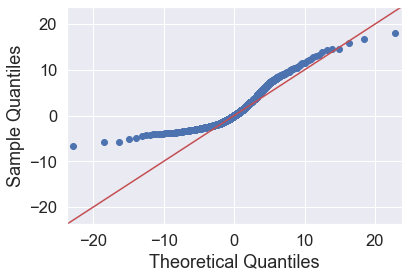

In [14]:
# viewing q-q plot of residuals
res = model.resid # residuals
fig = sm.qqplot(res, stats.t, fit=True, line='45')
plt.show()

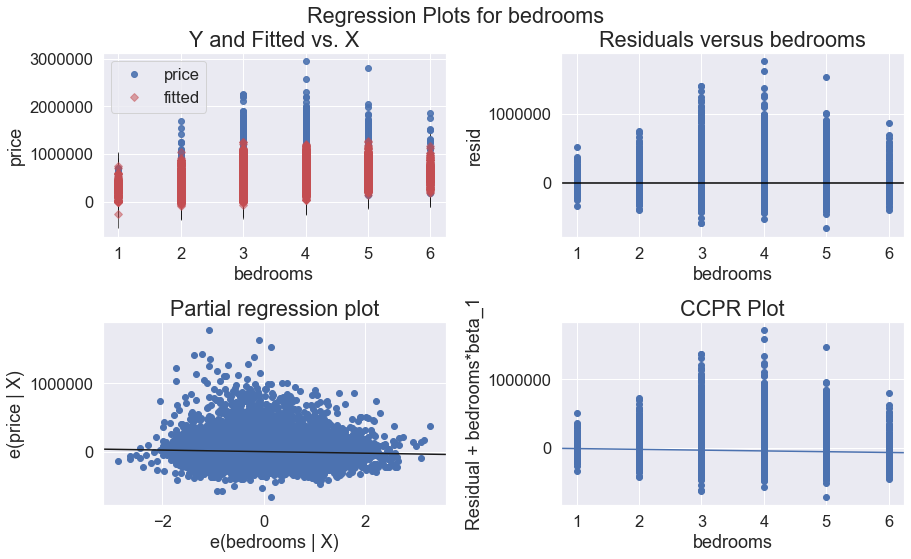

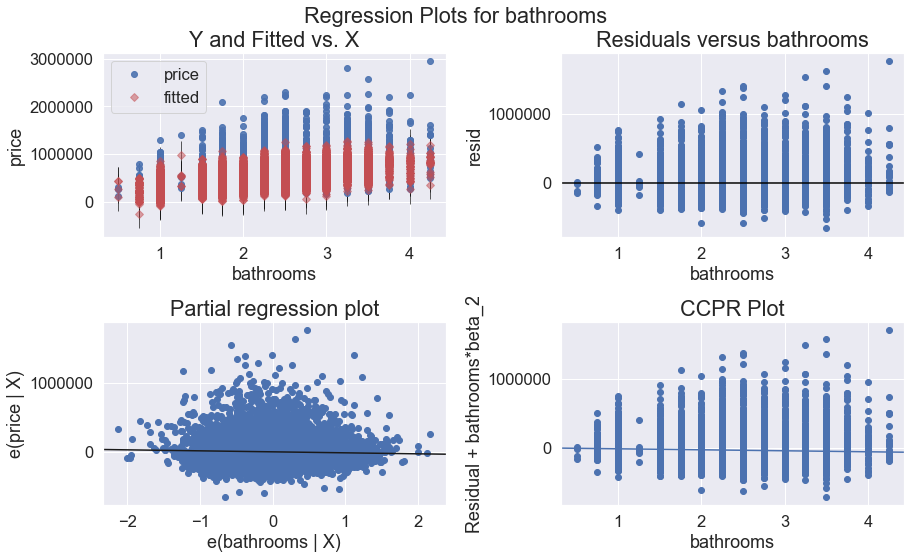

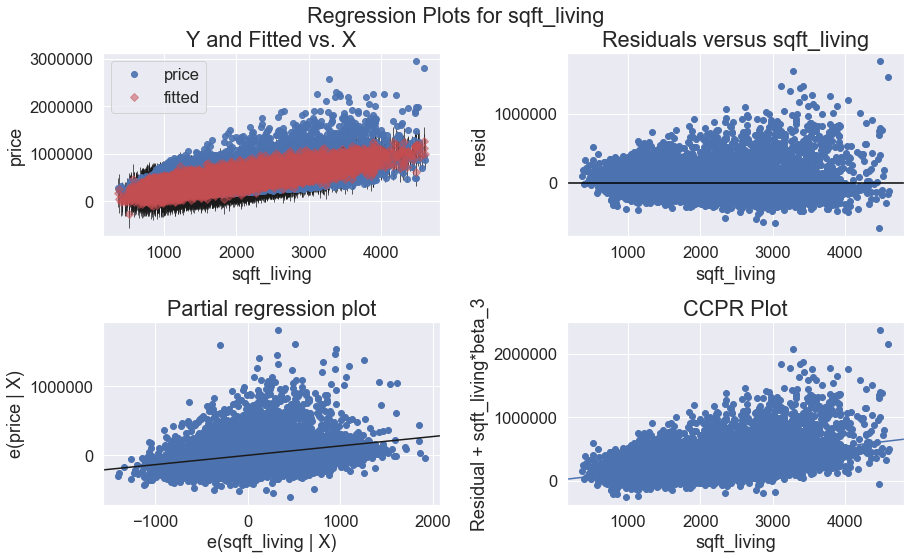

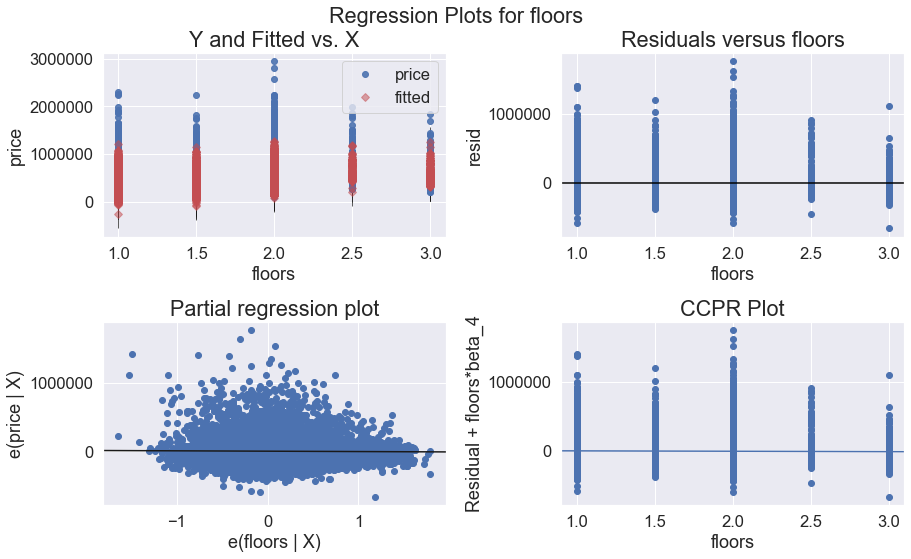

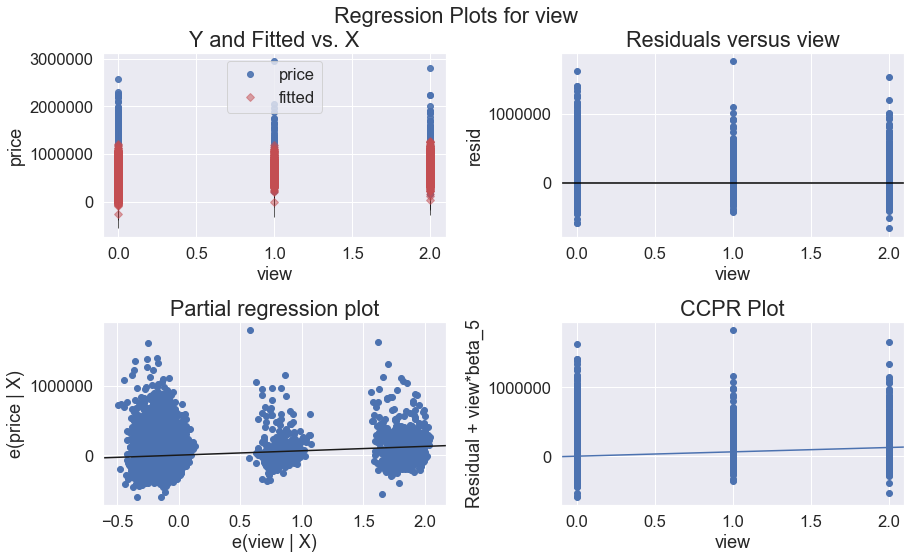

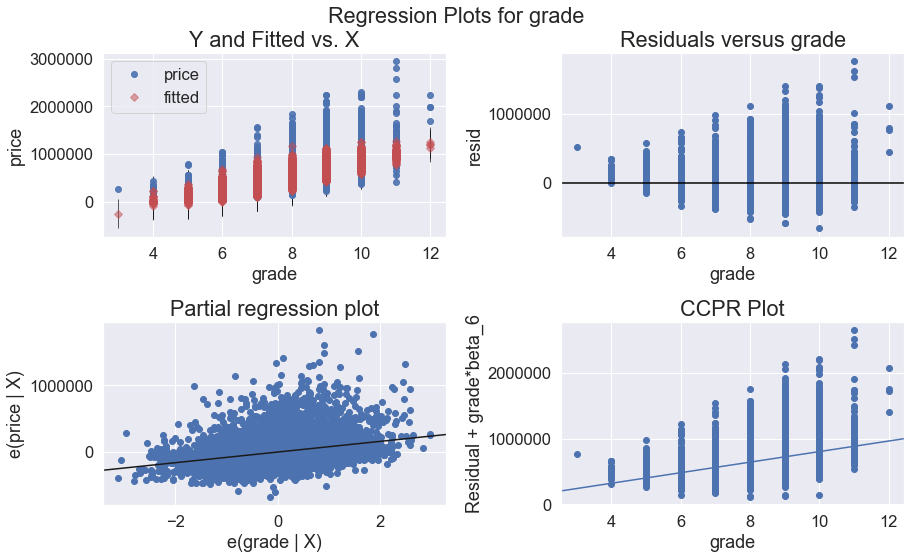

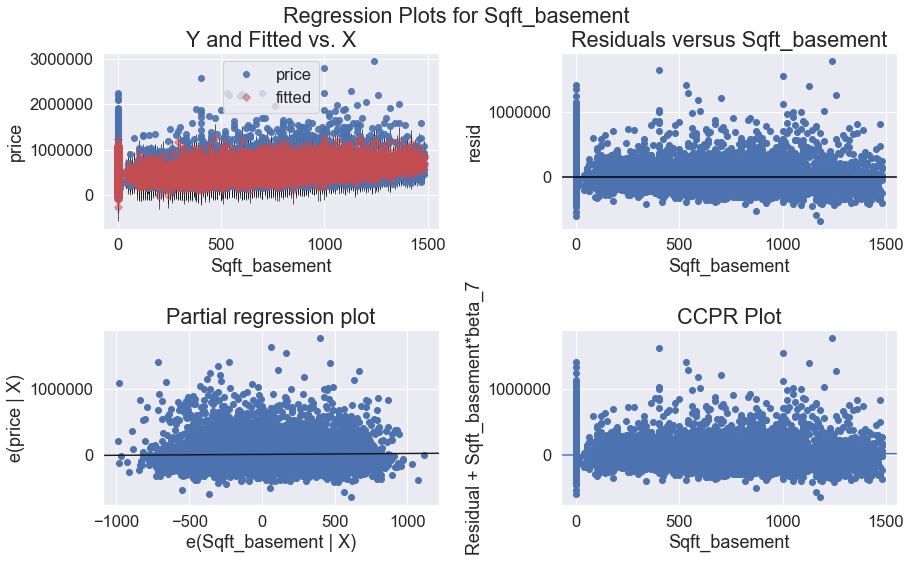

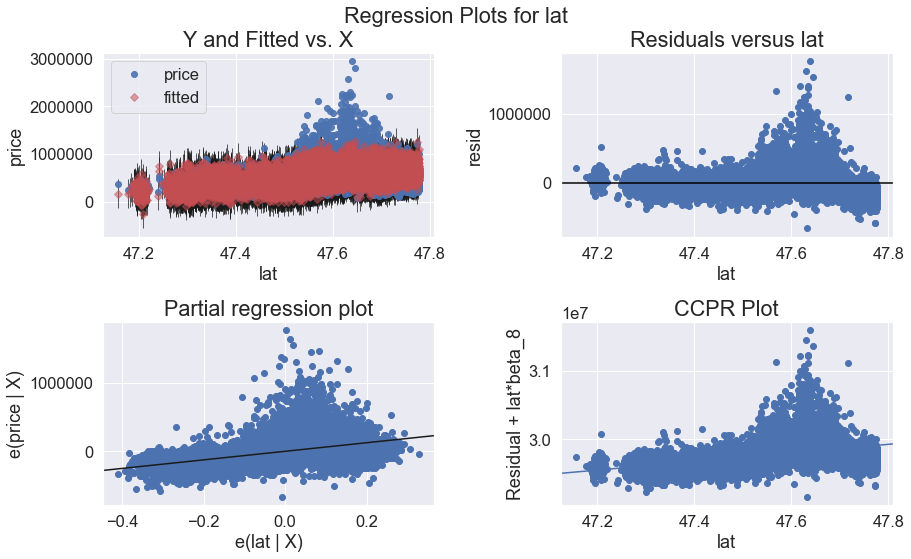

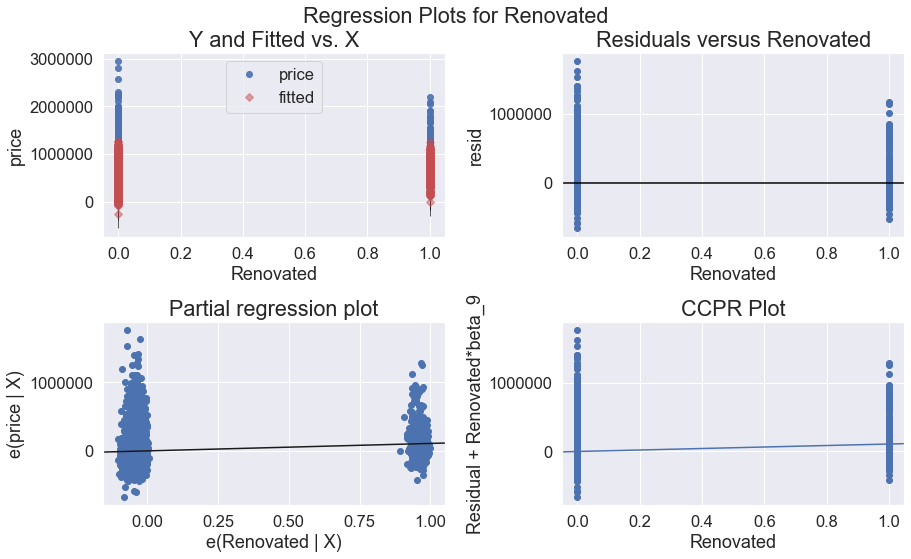

In [19]:
# viewing regression plots
for col in x_cols:
    fig = plt.figure(figsize=(13,8))
    fig = sm.graphics.plot_regress_exog(model, col, fig=fig)
    plt.show()
    print("="*72)

We saw correlation above 0.7 for `sqft_living` and `grade` and between `sqft_living` and `bathrooms`. I am tempted to see what happens when we remove two of these predictors at a time, leaving just one of them in the model.

Two of the three variables are categorical. Order matters, for `grade`, so we should not encode it; but perhaps we should one - hot encode `bathrooms`.

Note: `bedrooms`, `floors`, `view`, and `zipcode` each can be encoded, as well.

In [21]:
# copy all data to a new dataframe for encoding
hot_mod_df = mod_df.copy()

## Binning

There are more than a dozen unique values in the `bathrooms` column. Before encoding, we should segment the columns values into fewer bins.

To manage the half- and quarter- baths, we can bin this feature in the style '.5' for less than 1, '1' for homes with at least one and fewer than two bathroom(s), etc..

In [22]:
# what unique values do we currently have?
hot_mod_df.sort_values(by='bathrooms').bathrooms.unique()

array([0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  ,
       3.25, 3.5 , 3.75, 4.  , 4.25])

Currently, we have 16 unique values. Binning should reduce this to 4.

In [23]:
# creating the binned column, exclusive of 0 and inclusive of 4
bath_bins = pd.cut(hot_mod_df.bathrooms, 
                   bins=[0, .9, 1.9, 2.9, 3.9, 4], 
                   labels=['partial','1',
                           '2','3', '4'])
#insert the binned next to `bathrooms` column
hot_mod_df.insert(3,'Baths', bath_bins)

In [24]:
# view some rows with various bathroom counts
pd.set_option('display.max_rows', 20)
display(hot_mod_df.iloc[70:77, :])

# display bin column data type
hot_mod_df.Baths.dtype

,price,bedrooms,bathrooms,Baths,sqft_living,floors,view,grade,Sqft_basement,zipcode,lat,Renovated
81,360000.0,4,2.50,2,1900,2.0,0,7,0,98038,47.3490,0
82,355000.0,2,1.00,1,2020,1.0,0,7,1010,98118,47.5474,0
83,356000.0,3,1.50,1,1680,1.0,0,8,0,98059,47.4811,0
84,315000.0,3,1.00,1,960,1.0,0,6,0,98125,47.7264,0
85,940000.0,3,1.50,1,2140,2.0,0,9,240,98119,47.6337,0
86,305000.0,5,2.25,2,2660,1.5,0,7,0,98092,47.2909,0
87,461000.0,3,3.25,3,2770,2.0,0,9,790,98056,47.5228,0


CategoricalDtype(categories=['partial', '1', '2', '3', '4'], ordered=True)

## One - hot Encoding

In [25]:
# dropping the `bathrooms` column
hot_mod_df.drop('bathrooms', axis=1, inplace=True)

In [26]:
# creating a function to one - hot encode dataframe columns
def one_hot_encode(df, cols_list, a_type):
    """
    Setting 'df = one_hot_encode(...)' returns df 
    with the encoded columns added, and the source column dropped.
    """
    # generate dummies for listed columns
    for col in cols_list:
        df = pd.concat([df, pd.get_dummies(df[col],  # create columns
                                           prefix=col  # use source column name as prefix
                                           ).astype(a_type)], axis=1
                       ).drop([col], axis=1)  # drop source column
    return df

In [27]:
# using the function to one- hot encode the `Baths` feature
hot_mod_df = one_hot_encode(hot_mod_df, ['Baths'], int)

# viewing first rows of the encoded dataframe
hot_mod_df.head()

,price,bedrooms,sqft_living,floors,view,grade,Sqft_basement,zipcode,lat,Renovated,Baths_partial,Baths_1,Baths_2,Baths_3,Baths_4
0,221900.0,3,1180,1.0,0,7,0,98178,47.5112,0,0,1,0,0,0
1,538000.0,3,2570,2.0,0,7,400,98125,47.7210,1,0,0,1,0,0
2,180000.0,2,770,1.0,0,6,0,98028,47.7379,0,0,1,0,0,0
3,604000.0,4,1960,1.0,0,7,910,98136,47.5208,0,0,0,0,1,0
4,510000.0,3,1680,1.0,0,8,0,98074,47.6168,0,0,0,1,0,0


In [28]:
hot_mod_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19322 entries, 0 to 21596
Data columns (total 15 columns):
price            19322 non-null float64
bedrooms         19322 non-null int64
sqft_living      19322 non-null int64
floors           19322 non-null float64
view             19322 non-null int64
grade            19322 non-null int64
Sqft_basement    19322 non-null int64
zipcode          19322 non-null object
lat              19322 non-null float64
Renovated        19322 non-null int64
Baths_partial    19322 non-null int32
Baths_1          19322 non-null int32
Baths_2          19322 non-null int32
Baths_3          19322 non-null int32
Baths_4          19322 non-null int32
dtypes: float64(3), int32(5), int64(6), object(1)
memory usage: 2.0+ MB


## Model with One - Hot `Baths...`

In [29]:
# trying the model with the encoded columns
kicks = [col for col in hot_mod_df.columns if col not in ['price', 'zipcode']]
# set outcome ('target')
outcome = 'price'
# initialize variable for columns to submit to ols
x_cols = kicks
# define the formula to run the inputs
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model = ols(formula=formula, data=hot_mod_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     2264.
Date:                Sun, 01 Mar 2020   Prob (F-statistic):               0.00
Time:                        13:11:55   Log-Likelihood:            -2.5818e+05
No. Observations:               19322   AIC:                         5.164e+05
Df Residuals:                   19308   BIC:                         5.165e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.962e+07   3.89e+05    -76.239      0.000   -3.04e+07   -2.89e+07
bedrooms      -1.192e+04   1690.121     -7.050      0.000   -1.52e+04   -8602.850
sqft_living     130.6120      2.946     44.332      0.000     124.837     136.387
floors        -7925.0884   2781.548     -2.849      0.004   -1.34e+04   -2473.013
view           6.138e+04   2790.329     21.998      0.000    5.59e+04    6.69e+04
grade          8.019e+04   1685.974     47.562      0.000    7.69e+04    8.35e+04
Sqft_basement     6.9577      3.706      1.877      0.060      -0.306      14.222
lat            6.203e+05   8172.892     75.900      0.000    6.04e+05    6.36e+05
Renovated      1.029e+05   6444.991     15.962      0.000    9.02e+04    1.16e+05
Baths_partial -1.431e+05   3.82e+04     -3.743      0.000   -2.18e+05   -6.82e+04
Baths_1       -1.995e+05   3.32e+04     -6.011      0.000   -2.65e+05   -1.34e+05
Baths_2       -2.273e+05    3.3e+04     -6.894      0.000   -2.92e+05   -1.63e+05
Baths_3       -1.711e+05   3.31e+04     -5.171      0.000   -2.36e+05   -1.06e+05
Baths_4       -1.023e+05   3.99e+04     -2.564      0.010   -1.81e+05   -2.41e+04
==============================================================================
Omnibus:                     8651.292   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            83574.423
Skew:                           1.907   Prob(JB):                         0.00
Kurtosis:                      12.448   Cond. No.                     7.29e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

*****
That was a particularly minor improvement.

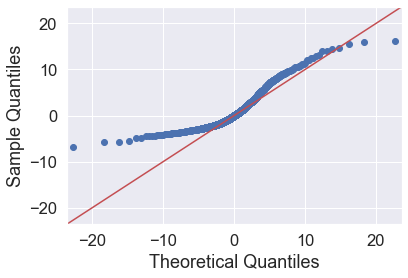

In [30]:
# viewing q-q plot of residuals
res = model.resid # residuals
fig = sm.qqplot(res, stats.t, fit=True, line='45')
plt.show()

That appears to be almost exactly forty - five degrees off, from our desired result.

# OLS and Collinearity

We saw that a few of our features are significantly correlated, and this may be part of our problem in building a reliable model. When predictor variables can predict one another, it is difficult to say with certainty which is responsible for any affect on the target variable.

Just as we isolated the target to build a model, we can isolate a predictor and see how strongly other variables are able to predict it by viewing the R2 score.

In [55]:
# check preditors for multicollinearity
for col in kicks:
    X = hot_mod_df[kicks].drop(columns=[col])
    y = hot_mod_df[col]
    linreg = sm.OLS(y, X)
    res = linreg.fit()
    print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:               bedrooms   R-squared (uncentered):                   0.963
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                          4.203e+04
Date:                Sun, 01 Mar 2020   Prob (F-statistic):                        0.00
Time:                        15:16:36   Log-Likelihood:                         -19275.
No. Observations:               19322   AIC:                                  3.857e+04
Df Residuals:                   19310   BIC:                                  3.867e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

                                 OLS Regression Results                                
Dep. Variable:                  grade   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                          2.097e+05
Date:                Sun, 01 Mar 2020   Prob (F-statistic):                        0.00
Time:                        15:16:37   Log-Likelihood:                         -19412.
No. Observations:               19322   AIC:                                  3.885e+04
Df Residuals:                   19310   BIC:                                  3.894e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

                                 OLS Regression Results                                
Dep. Variable:          Baths_partial   R-squared (uncentered):                   0.761
Model:                            OLS   Adj. R-squared (uncentered):              0.761
Method:                 Least Squares   F-statistic:                              5121.
Date:                Sun, 01 Mar 2020   Prob (F-statistic):                        0.00
Time:                        15:16:37   Log-Likelihood:                          40987.
No. Observations:               19322   AIC:                                 -8.195e+04
Df Residuals:                   19310   BIC:                                 -8.186e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

                                 OLS Regression Results                                
Dep. Variable:                Baths_4   R-squared (uncentered):                   0.676
Model:                            OLS   Adj. R-squared (uncentered):              0.675
Method:                 Least Squares   F-statistic:                              3351.
Date:                Sun, 01 Mar 2020   Prob (F-statistic):                        0.00
Time:                        15:16:38   Log-Likelihood:                          41815.
No. Observations:               19322   AIC:                                 -8.361e+04
Df Residuals:                   19310   BIC:                                 -8.351e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

R2 scores greater than __0.67__ indicate that `bedrooms`, `sqft_living`, `floors`, 
`grade`, `lat`, and `Baths...` columns can be predicted by other columns and 
collinearity is present. Consequently, we need to narrow our feature selection
to reduce multicollinearity between predictors.

# Validating the Model

Let's check our model in sklearn.

In [33]:
# Run the same model in sci - kit learn
X = hot_mod_df[x_cols]
y = hot_mod_df[outcome]

linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [34]:
# coefficients
linreg.coef_




array([-1.19156331e+04,  1.30611956e+02, -7.92508838e+03,  6.13823041e+04,
        8.01890250e+04,  6.95769371e+00,  6.20324046e+05,  1.02872500e+05,
       -1.43106358e+05, -1.99499449e+05, -2.27341328e+05, -1.71061217e+05,
       -1.02308636e+05])

The coefficients match those computed with statsmodels.


In [35]:
# intercept
linreg.intercept_

-29622780.553060748

In [36]:
# testing on 30% of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30) 

In [37]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13525, 13), (5797, 13), (13525,), (5797,))

In [38]:
linreg = LinearRegression(fit_intercept=False)

In [40]:
# train the model on our test data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [41]:
# find Beta0 coefficients
linreg.coef_

array([-2.03158664e+04,  1.13771664e+02,  7.92806881e+03,  5.86550206e+04,
        9.60087236e+04,  5.52059235e+01,  5.65766460e+01,  1.22870788e+05,
       -3.67283339e+05, -4.09003660e+05, -4.53837642e+05, -3.82625291e+05,
       -3.29684509e+05])

In [46]:
# get R2
r2 = linreg.score(X_test, y_test).round(3)

# view the sklearn R - squared score for the model
print("R - squared:", r2)

R - squared: 0.486


## Compare R2 Scores for Train and Test Sets

In [48]:
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [50]:
r2_score(y_train, y_hat_train).round(3), r2_score(y_test, y_hat_test).round(3)

(0.484, 0.486)

R2 scores are close, indicating that the data is not over - fit.

## Cross Fold Validation

In [54]:
# validate on 5 folds (testing 20% of data each time)
cv_linreg = cross_val_score(linreg, X, y, cv=8, scoring='r2')

# view R2 for each fold
cv_linreg

array([0.46701613, 0.46599392, 0.48132139, 0.43574164, 0.48281755,
       0.49012726, 0.4888045 , 0.52814012])

Scores are still close. This indicates that we have a valid model.

* What do we think about the model
* We can build a model in sklearn
* get parameters
* write out your equation
* indicate how affected `price` is by features
* make recommendations
* low coefficients will not affect the target as much as high coefficients

What does it look like without our encoded columns?

## Model without `Baths...`

In [ ]:
# trying the model without `sqft_living` and `grade`
kicks = [col for col in hot_mod_df.columns if col not in ['price', 'zipcode'] and 'Baths' not in col]
# set outcome ('target')
outcome = 'price'
# initialize variable for columns to submit to ols
x_cols = kicks
# define the formula to run the inputs
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model = ols(formula=formula, data=hot_mod_df).fit()
model.summary()

...Only a tiny change, and in the wrong direction. 

Let's restore the 'Baths' features and try it without `sqft_living`.

## Model without `sqft_living`

In [ ]:
# trying the model without `sqft_living`
kicks = [col for col in hot_mod_df
         .columns if col not in ['price', 'zipcode', 
                                 'sqft_living']]
# set outcome ('target')
outcome = 'price'
# initialize variable for columns to submit to ols
x_cols = kicks
# define the formula to run the inputs
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model = ols(formula=formula, data=hot_mod_df).fit()
model.summary()

...Only a small improvement in kurtosis. Let's also run it without `grade`.

## Model without `sqft_living` and `grade`

In [ ]:
# trying a model without `bathrooms` and `sqft_living`
kicks = [col for col in hot_mod_df
         .columns if col not in ['price', 
                              'zipcode', 
                              'sqft_living', 
                              'grade'
                             ]]
outcome = 'price'# set outcome ('target')
# initialize variable for columns to submit to ols
x_cols = kicks
# define the formula to run the inputs
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model = ols(formula=formula, data=hot_mod_df).fit()
model.summary()

Slightly worse skew and kurtosis.

## Model with Only `bedrooms` and `Baths...`

In [ ]:
hot_mod_df.columns

In [ ]:
# trying a model without `bathrooms` and `sqft_living`
kicks = ['sqft_living', 'floors', 'view', 'grade',
       'Renovated', 'Baths_partial',
       'Baths_1', 'Baths_2', 'Baths_3', 'Baths_4']
outcome = 'price'  # set outcome ('target')
# initialize variable for columns to submit to ols
x_cols = kicks
# define the formula to run the inputs
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model = ols(formula=formula, data=hot_mod_df).fit()
model.summary()

***
The combination with the lowest skew and the higest R - squared was the first model we ran with encoded baths. Beyond that, the impact of most changes to the model were minimal. Let's see whether encoding `grade` makes a difference.

## Encoding `grade`

In [ ]:
# using the function to one- hot encode the `grade` feature
hot_mod_df = one_hot_encode(hot_mod_df, ['grade'], int)

# viewing first rows of the encoded dataframe
hot_mod_df.head()

## Model with One - Hot `grade`

In [ ]:
# trying the model with the encoded columns
kicks = [col for col in hot_mod_df.columns if col not in [
    'price', 'zipcode']]
# set outcome ('target')
outcome = 'price'
# initialize variable for columns to submit to ols
x_cols = kicks
# define the formula to run the inputs
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model = ols(formula=formula, data=hot_mod_df).fit()
model.summary()

Here we see, finally, just a hint of improvement.

> Perhaps it is time to get the band back together. Let's restore `zipcode` to the list of features and encode relevant categoricals for modeling.

# Remaining One - hots

In [ ]:
# using the function to one- hot encode relevant feature
hot_mod_df = one_hot_encode(
    hot_mod_df, ['bedrooms', 'floors', 'view', 'zipcode'], int)

# viewing first rows of the encoded dataframe
hot_mod_df.head()

Our `floors...` have decimals: let's fix those.

In [ ]:
hot_mod_df = hot_mod_df.rename(
    columns={'floors_1.0': 'floors_1_0', 'floors_1.5': 'floors_1_5',
             'floors_2.0': 'floors_2_0', 'floors_2.5': 'floors_2_5',
             'floors_3.0': 'floors_3_0'})

hot_mod_df.head(1)

# Supermodel
### Viewing a model with `zipcode` and all one - hot encodes

In [ ]:
# trying the model with the encoded columns
kicks = [col for col in hot_mod_df.columns if col not in [
    'price']]
# set outcome ('target')
outcome = 'price'
# initialize variable for columns to submit to ols
x_cols = kicks
# define the formula to run the inputs
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model = ols(formula=formula, data=hot_mod_df).fit()
model.summary()

That is quite a jump, though the inclusion of `zipcode` fields as integers complicates interpretation.

In [ ]:
# viewing q-q plot of residuals
res = model.resid # residuals
fig = sm.qqplot(res, stats.t, fit=True, line='45')
plt.show()

In [ ]:
# instantiating a correlations table
hot_corr = hot_mod_df.corr()

# finding correlations (with price) above 0.3
hot_corr3 = hot_mod_df.corr().abs() >= 0.3

# setting to view all rows
pd.set_option('display.max_rows', 123)

# viewing correlations with price above 0.3
hot_corr3.loc[hot_corr3['price'] == True, ['price']]

In [ ]:
plot_corr_heatmap(hot_mod_df.iloc[:16, :16].corr().abs())

## Viewing residual distributions

In [ ]:
res = model.resid # residuals
fig = sm.qqplot(res, stats.t, fit=True, line='45')
plt.show()

The qq-plot indicates that residuals for our model do not reflect a good fit.

### Viewing predictor residuals separately

In [ ]:
# instantiate a model variable for the loop
fitted = model

# view residual fit for each tested independent variable
for c in feats:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. \nModel residuals".format(c),fontsize=16)
    plt.scatter(x=hot_mod_df[c], y=fitted.resid, color='blue', edgecolor='k')
    plt.grid(True)
    xmin=min(mod_df[c])
    xmax = max(hot_mod_df[c])
    # add y=0 line across data with space from side edges
    plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
    plt.xlabel(c,fontsize=14)
    plt.ylabel('Residuals',fontsize=14)
    plt.show()

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(fitted.resid_pearson,bins=20,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Residuals',fontsize=15)
plt.title("Histogram of residuals",fontsize=18)
plt.show()

In [ ]:
log_df = mod_df.copy()
log_df.columns

In [ ]:
custom_palette = sns.color_palette("Dark2")
positives = [c for c in feats if log_df[c].min() > 0]
# 
# for c in positives:
#     sns.pairplot(
#             log_df, x_vars=log_df[positives], y_vars='price',
#             palette=custom_palette, height=6, aspect=.8, kind="reg",
#             plot_kws={'line_kws': {'color': 'red'}}
#         )
positives

### Q-Q Plot

Checking linearity with Q-Q Plots

In [ ]:
# import the required library
from statsmodels.graphics.gofplots import qqplot

In [ ]:
# qq-plotting select columns
for col in mod_df:
    if col in feats:
        sm.qqplot(mod_df[col], stats.t, fit=True, line='45')

plt.subplots_adjust(wspace=.35, hspace=1)
plt.title('QQ-Plot', va='bottom')
ylabel='test_this'
plt.show()

> Those definitely are not normal. What is going on, here?
* Some predictor variables, like 'bedrooms', are discrete.

In [ ]:
sm.qqplot(mod_df['bedrooms'], line='45')

Others, such as `sqft_living` are not normally distributed

In [ ]:
sm.qqplot(mod_df['sqft_living'], line='45')

> We have many options for corrections:
* Address collinearity issues between 'sqft_living' and 'Sqft_basement' by creating a boolean 'Basement' feature, instead.
* One - hot encode categorical variables.
* Log transform some of our features.
* Use minmax scaling to scale features.

Let's review what we have to work with.

In [ ]:
mod_df.columns

## Jarque - Bera and Kurtosis
## Questions and Desired Variables
## Model & Testing
## Conclusion

### Review Assumptions for Linear Regression

- Linearity between target and predictor variables
    - Previewed above, but the scales may be a bit unbalanced, yet
- Normality of model residuals
    - Verify after building a baseline model
- Homoscedasticity: equal variability of a dependent variable across the values of an independent variable
    - Review after normalizing data
- Absence of, or minimal multicollinearity
    - We will need to select the best and discard the rest from multicollinear variables 

In [ ]:
# custom_palette = sns.color_palette("Dark2")
# sns.pairplot(no_hots_df, x_vars=["bedrooms", "sqft_basement"], y_vars=["price"],
#              hue="waterfront", palette=custom_palette, height=5, aspect=.8, kind="reg");

## Pickle the model / current - state dataframe

Store the `*****` dataframe in a sub - directory of the repository as `****************`.

In [ ]:
# with open('data/*****.pickle', 'wb') as f:
#     # Pickling the '******' dataframe using the highest protocol available.
#     pickle.dump(******, f, pickle.HIGHEST_PROTOCOL)

## Questions Asked

## Questions Answered

## Next

* 

# Notes
***

In [ ]:
# import gc
# gc.get_count()
# gc.collect()
# gc.get_count()

## Dealing with Outliers

In [ ]:
# from scipy import stats

### Taking a look at how far out our outliers are

In [ ]:
# creating a function to identify columns in a dataframe
# with values more than 3 standard deviations from the mean
# def check_outliers(df, col):
#     std_min = df[col].mean() - 3*df[col].std()
#     std_max = df[col].mean() + 3*df[col].std()
#     if df[col].min() < std_min or df[col].max() > std_max:
#         print(f"\nValue in {col} exceeds +/- 3 standard deviations")
#         print(f"column max: {df[col].max()}, std.dev. max: {std_max}")
#         print(f"column mini: {df[col].min()}, std.dev. min: {std_min}")
#         print("-"*72)

# parking lot:

> 

In [ ]:
# no_hots_df.sqft_above.hist(alpha=.6, color='red')
# sqs.sqft_above.hist(alpha=.6, color='green')
# sqs_3000.sqft_above.hist(alpha=.6, color='blue')

# plt.show()

In [ ]:
# no_hots_df.sqft_lot.apply(np.log).hist(alpha=.5)
# no_hots_df.sqft_lot15.apply(np.log).hist(alpha=.3)
# plt.show()

In [ ]:

# plt.figure(figsize=(8,4))
# plt.hist(target, color='orange')
# plt.show()

In [ ]:
# scatter plot a map
# df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2)
# plt.savefig('map1.png')

# Feature Engineering

## `Sqft_basement` to boolean

In [ ]:
# creating a new boolean column
# returning True for 'Sqft_basement' > 1 in each row
mod_df['Basement'] = (mod_df['Sqft_basement'].round() > 1
                          ).astype('int64')
# view the dataframe first rows with new feature
display(mod_df.head())

In [ ]:
custom_palette = sns.color_palette("Dark2")

sns.pairplot(
    mod_df, x_vars=['bedrooms',
 'bathrooms',
 'sqft_living',
 'floors',
 'view',
 'grade',
 'Sqft_basement'], y_vars='price',
    palette=custom_palette, height=6, aspect=.8, kind="reg",
    plot_kws={'line_kws': {'color': 'red'}}
)

In [ ]:
# viewing a pairplot for regression model columns
# sns.pairplot(mod_df[x_cols], kind="reg", plot_kws={'line_kws':{'color':'orange'}})
# sns.set(font_scale=.8) # try to prevent overlap of long column names
# plt.subplots_adjust(wspace=.01, hspace=.1);
# plt.show()

I think it only makes sense to focus on the `sqft` features for log transformation.

## OLS and Collinearity

In [ ]:
# plt.figure(figsize=(8,4))
# plt.hist(target, color='orange')
# plt.show()

In [ ]:
# viewing pairwise relationships
# sns.pairplot(data_f)

# plt.show()

The pairplots give a feel for just how much of the data is categorical.

In [ ]:
# set outcome ('target')
outcome = 'price'
# initialize variable for columns to submit to ols
x_cols2 = ['zipcode']
# define the formula to run the inputs
predictors = '+'.join(x_cols2)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model2 = ols(formula=formula, data=mod_df).fit()
model2.summary()

In [ ]:
test_adds = [f for f in feats if f != 'sqft_living' and f != 'bathrooms']
test_adds

In [ ]:
feats